This project involves the usage of Reddit scraping tools on a Nintendo Switch 2 subreddit. After accumulating a dataframe with 100 new posts from the subreddit, the text will be cleaned and subjected to VADER sentiment Analysis tool. Based on the VADER results we will run topic modeling to further understand the reasoning for why posts are deemed negative or positive and what these implications mean for Nintendo.

# Importing Data

The praw package allows us to utilize the Reddit Application Programming Interface (API) which further allows us to extract posts from Reddit, in particular the newest 100 posts from a Nintendo Switch 2 subreddit.

In [4]:
pip install praw


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Praw imports my identification information that was provided to me when I registerd on Reddit's website to use the API. This includes the 'client_id', 'client_secret', and 'user_agent'. The subreddit is then chosen from Reddit and the newest 100 posts are extracted. The 100 post limit was expressed in the Reddit API terms and agreements. From there each post was extracted with a unique id, the post title, its url, the submission score (net upvotes minus downvotes), the time it was created, the number of comments on the post, and the text within the post.<br>
<br>
These were appended to an empty list which was then converted to a data frame where it could be analyzed.

Below code generated by ChatGPT <br>
<br>
OpenAI. (2025). ChatGPT (June 14 version) [Large language model]. https://chat.openai.com/

In [7]:
#import praw

#Reddit API Authentication provided by my Reddit request
#reddit = praw.Reddit(
    #client_id='7sIcX5qorffeq4iEYBgKow',
    #client_secret='unCMiTrggYY0qeaRhN6pv2DZtlrRMA',
    #user_agent='MSDA 618 Final by /u/AsleepEconomist4792'
#)

#Accesses Reddit and chooses the Nintendo Switch 2 subreddit to extract from
#subreddit = reddit.subreddit('NintendoSwitch2')
#posts = []

# fetches and extracts the newest 100 posts from the aforementioned subreddit
#for submission in subreddit.new(limit=100):  
    #posts.append({
        #'id': submission.id,
        #'title': submission.title,
        #'url': submission.url,
        #'score': submission.score,
        #'created_utc': submission.created_utc,
        #'num_comments': submission.num_comments,
        #'body': submission.selftext
    #})


#converts the compiled extracted posts into a data frame for modeling and analysis
#df = pd.DataFrame(posts)



In [8]:
import pandas as pd
import numpy as np
import requests
pd.set_option('display.max_colwidth', 500)
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

## Saving Dataset as CSV

This is important for this project, for if I want to analyze data I need to make sure that the data doesnt get overwritten by new posts. This code provided by ChatGPT will save the dataset and allow it to be visible to any other parties than myself with the csv document. Once this code has been run once it can be omitted to prevent any overwriting or unnecessary csv downloading.

In [10]:
from datetime import datetime

#timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
#df.to_csv(f"nintendo_switch2_posts_{timestamp}.csv", index=False)

In [11]:
df = pd.read_csv("nintendo_switch2_posts_20250624_005046.csv")

In [12]:
df.head()

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive
1,1lix7ls,What's your kickstand position,https://i.redd.it/htwf0jobsr8f1.jpeg,2,1.750725e+09,1,Personally mines hook,personally mine hook,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
2,1lix33y,Is it worth buying Cyberpunk 2077?,https://www.reddit.com/r/NintendoSwitch2/comments/1lix33y/is_it_worth_buying_cyberpunk_2077/,1,1.750725e+09,3,How fun is it? What's your opinion?\n\n[View Poll](https://www.reddit.com/poll/1lix33y),fun whats opinion view pollhttpswwwredditcompolllixy,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.5106}",positive
3,1liwzvq,Savage Raven Case/Grip,https://www.reddit.com/gallery/1liwzvq,8,1.750724e+09,4,"I just got my case in. I took a slow approach with looking for a case. After looking at a few reviews, I settled on the Savage Raven case and neo grip.\n\nIt feels amazing. The outside is sturdy and the inside extremely soft. The grip comes with three attachment options. I can confirm that the grip with the smallest attachments can fit in this case, which is the smaller of the Savage Raven cases. For stability though, the trigger grip (far left of picture 4) feels the most secure while playi...",get case take slow approach look case look review settle savage raven case neo grip feel amaze outside sturdy inside extremely soft grip come three attachment option confirm grip small attachment fit case small savage raven case stability though trigger grip far leave picture feel secure play anyone fence confirm good quality last entire handheld generation good luck,"{'neg': 0.093, 'neu': 0.596, 'pos': 0.311, 'compound': 0.9413}",positive
4,1liwzpm,Love to take this thing out with me,https://i.redd.it/twgb4c1gqr8f1.jpeg,37,1.750724e+09,8,Waited 3.5 hours at the urgent care because my face swelled up. It made the wait so easy. Loving the switch 2,waited hour urgent care face swell make wait easy loving switch,"{'neg': 0.0, 'neu': 0.372, 'pos': 0.628, 'compound': 0.8957}",positive


In [13]:
df.shape

(100, 10)

# Cleaning Data

Once our data is compiled we want to clean the text in each document. The first thing to occur is for the document to be lowercased entirely and for hyphens and any other special characters/ punctuation to be removed and replaced by empty spaces. <br>
<br>
Next the document will be tokenized. Tokenization can be thought of by which the words in the document are separated to be processed individually rather than as a complete document. Each word that is tokenized will be assessed by the list of stop words that are provided by the nltk.corpus as well as any additional words added on. If the stop words is present, then that word(s) will be removed. <br>
<br>
Lastly, we need to lemmatize this newly cleaned document data. To do that we are going to run a lemmatizer tool 'Word Net Lemmatizer' which groups similar words such as 'gone', 'going', 'went' into one word 'go'. This reduces the total number of words that are analyzed, reducing the necessary computing power required, reducing the total amount of words present, and making analysis more intuitive. The lemmatizer works best when words are separated first by their 'part of speech' (noun, verb, etc.). <br>
<br>

In [16]:
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words("english") 
my_stopwords = nltk_stopwords + ["000", "mr", "said", "says","say", "ms"]

In [17]:
wnl = WordNetLemmatizer()

# Helper function to map NLTK POS tags to WordNet POS tags
# This ensures lemmatization is as accurate as possible
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

# Clean text function
def clean_text(text):
    # Replace hyphens with spaces before removing punctuation
    text = re.sub(r'-', ' ', text.lower())  # Replace hyphens with spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove everything else

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in my_stopwords]

    # POS tagging and lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [wnl.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return ' '.join(lemmatized)

In [18]:
# apply to text column
df['cleanbody'] = df['body'].astype(str).apply(clean_text)

In [19]:
df.head()

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive
1,1lix7ls,What's your kickstand position,https://i.redd.it/htwf0jobsr8f1.jpeg,2,1.750725e+09,1,Personally mines hook,personally mine hook,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
2,1lix33y,Is it worth buying Cyberpunk 2077?,https://www.reddit.com/r/NintendoSwitch2/comments/1lix33y/is_it_worth_buying_cyberpunk_2077/,1,1.750725e+09,3,How fun is it? What's your opinion?\n\n[View Poll](https://www.reddit.com/poll/1lix33y),fun whats opinion view pollhttpswwwredditcompolllixy,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.5106}",positive
3,1liwzvq,Savage Raven Case/Grip,https://www.reddit.com/gallery/1liwzvq,8,1.750724e+09,4,"I just got my case in. I took a slow approach with looking for a case. After looking at a few reviews, I settled on the Savage Raven case and neo grip.\n\nIt feels amazing. The outside is sturdy and the inside extremely soft. The grip comes with three attachment options. I can confirm that the grip with the smallest attachments can fit in this case, which is the smaller of the Savage Raven cases. For stability though, the trigger grip (far left of picture 4) feels the most secure while playi...",get case take slow approach look case look review settle savage raven case neo grip feel amaze outside sturdy inside extremely soft grip come three attachment option confirm grip small attachment fit case small savage raven case stability though trigger grip far leave picture feel secure play anyone fence confirm good quality last entire handheld generation good luck,"{'neg': 0.093, 'neu': 0.596, 'pos': 0.311, 'compound': 0.9413}",positive
4,1liwzpm,Love to take this thing out with me,https://i.redd.it/twgb4c1gqr8f1.jpeg,37,1.750724e+09,8,Waited 3.5 hours at the urgent care because my face swelled up. It made the wait so easy. Loving the switch 2,waited hour urgent care face swell make wait easy loving switch,"{'neg': 0.0, 'neu': 0.372, 'pos': 0.628, 'compound': 0.8957}",positive


# Sentimment Analysis Tool - VADER 
## (Valence Aware Dictionary and sEntiment Reasoner)

The sentiment analysis tool that is going to be used for this dataset is the VADER tool. This tool is the best option because it has the capabilities of handling slang terms and word intensifers (e.g. very, super, etc.) often seen in social media, reviews, and in our case Reddit. It works by analyzing the cleaned document text and tallying points based on their tones (for example: great -> +, while bad -> -). After the total document is scanned the compound score will determine if the overall tone of the document was positive (>= 0.05), neutral ( > -0.05 and < 0.05), or negative (<= 0.05).

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer() #initialize sentiment analyzer

In [23]:
df['vader_scores'] = df['cleanbody'].apply(lambda review: vader.polarity_scores(review))
df.head(1)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive


__compound score__ is the normalized score, where -1 is extremely negative and +1 is extremely positive. <br>

__positive sentiment__ : (compound score >= 0.05) <br>
__neutral sentiment__ : (compound score > -0.05) and (compound score < 0.05) <br>
__negative sentiment__ : (compound score <= -0.05) <br>

The code below will help lable each document as being positive, neutral, or negative.
Code provided by:  https://hex.tech/use-cases/sentiment-analysis/vader-sentiment-analysis/

In [25]:
def extract_score(text):
    score = vader.polarity_scores(text)
    compound = score['compound']

    sentiment = 'neutral'
    if(compound >= 0.05):
        sentiment = "positive"

    elif(compound <= -0.05):
        sentiment = "negative"

    return sentiment

This will take the vader scores of each document and correctly label them as positive, neutral, or negative in a corresponding column, 'vader'

In [27]:
df['vader'] = df['cleanbody'].apply(extract_score)

In [28]:
df.head(5)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive
1,1lix7ls,What's your kickstand position,https://i.redd.it/htwf0jobsr8f1.jpeg,2,1.750725e+09,1,Personally mines hook,personally mine hook,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
2,1lix33y,Is it worth buying Cyberpunk 2077?,https://www.reddit.com/r/NintendoSwitch2/comments/1lix33y/is_it_worth_buying_cyberpunk_2077/,1,1.750725e+09,3,How fun is it? What's your opinion?\n\n[View Poll](https://www.reddit.com/poll/1lix33y),fun whats opinion view pollhttpswwwredditcompolllixy,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.5106}",positive
3,1liwzvq,Savage Raven Case/Grip,https://www.reddit.com/gallery/1liwzvq,8,1.750724e+09,4,"I just got my case in. I took a slow approach with looking for a case. After looking at a few reviews, I settled on the Savage Raven case and neo grip.\n\nIt feels amazing. The outside is sturdy and the inside extremely soft. The grip comes with three attachment options. I can confirm that the grip with the smallest attachments can fit in this case, which is the smaller of the Savage Raven cases. For stability though, the trigger grip (far left of picture 4) feels the most secure while playi...",get case take slow approach look case look review settle savage raven case neo grip feel amaze outside sturdy inside extremely soft grip come three attachment option confirm grip small attachment fit case small savage raven case stability though trigger grip far leave picture feel secure play anyone fence confirm good quality last entire handheld generation good luck,"{'neg': 0.093, 'neu': 0.596, 'pos': 0.311, 'compound': 0.9413}",positive
4,1liwzpm,Love to take this thing out with me,https://i.redd.it/twgb4c1gqr8f1.jpeg,37,1.750724e+09,8,Waited 3.5 hours at the urgent care because my face swelled up. It made the wait so easy. Loving the switch 2,waited hour urgent care face swell make wait easy loving switch,"{'neg': 0.0, 'neu': 0.372, 'pos': 0.628, 'compound': 0.8957}",positive


Now we can visualize the total number of each positive, neutral, and negative reviews labeled by VADER. Based on the results there are a large amount of positive posts (54) on the Nintendo Switch 2 Reddit page with a smaller number of negative posts (20)

In [30]:
df['vader'].value_counts()

vader
positive    54
neutral     26
negative    20
Name: count, dtype: int64

<Axes: xlabel='vader'>

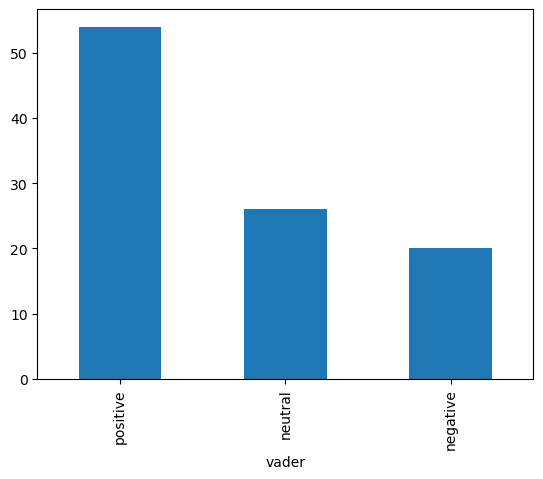

In [31]:
df['vader'].value_counts().plot(kind='bar')

These results tell us that majority of posts on the Nintendo Switch 2 Reddit page are positive which is an ideal outcome from a business perspective. But while this tells us general tones of the Reddit posts, it remains unclear about what users on Reddit are referring to when posting. <br>
<br>
<br>
In order to further our exploration into this idea, Topic modeling can be run on the positive posts giving insight about what users like about the product as well as negative posts to give insight about what users may dislike about the product. Positive aspects of the Switch 2 can be used in future marketing while negative posts should then be used by businesses to determine potential changes that can made to the Nintendo Switch 2 product that improves the consumer's experience.

# Topic Modeling: Using Non-Negative Matrix Factorization (NMF)

NMF is a fast and interpretable tool used to produce well-defined topics based on groups of words throughout the documents. NMF is also great for the type of documents that are being processed as they are short texts compared to other tools that prefer longer texts.

# Vectorizer on Positive Posts



In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import math

The code below will allow us to run the topic modeling on a copy of the original dataframe that only includes posts classified as 'positive' by the VADER sentiment analysis model. After both positive and negative topic modeling are complete they can be joined into the original dataframe for completeness.

In [38]:
df_pos = df[df['vader'] == 'positive'].copy()  

In [39]:
df_pos.shape

(54, 10)

In [40]:
df_pos.head(1)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive


In [41]:
# with additional stop words to clear up positive topics
nltk_stopwords = stopwords.words("english") 
my_stopwords = nltk_stopwords + ["000", "mr", "said", "says","say", "ms", "thing", "something", "seem"] + ["anything", "im", "would", "look", "step"]

This is the first step in order to begin our NMF analysis. A vectorizer tokenizes each word in the document allowing each word to be counted (Count Vectorizer) or weighed in relation to the rest of the document (TF-IDF Vectorizer). For this project I will be using the TD-IDF Vectorizer as it is generally better to use with NMF that examines text shorter in length and each word is better represented by weight instead of count. This vectorizer is run on the 'cleanbody' column which includes the post text that has been lemmatized with stop words have been removed. Stop words for this section to include "anything", "im", "would", "look", "step". This was done as they were commonly seen words in the topics that did not aid in creating a general topic name.

In [43]:
# instantiate vectorizer
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words= my_stopwords, 
                        max_df=0.95, 
                        min_df=0.05,
                        ngram_range = (1,2)) 


tfidf_dm = tfidf.fit_transform(df_pos['cleanbody'])

# print matrix shape(s)
print(tfidf_dm.shape)

names = tfidf.get_feature_names_out()
print(type(names), len(names))
#save this feature list for later
big_feature_list = tfidf.get_feature_names_out()

(54, 203)
<class 'numpy.ndarray'> 203


In [44]:
print(big_feature_list)

['able' 'access' 'accessory' 'ago' 'allow' 'already' 'also' 'anyone'
 'anyone else' 'around' 'ask' 'avoid' 'back' 'bananza' 'believe' 'best'
 'big' 'bit' 'black' 'bonus' 'botw' 'box' 'brand' 'break' 'button' 'buy'
 'cant' 'case' 'code' 'come' 'compatibility' 'compatible' 'con' 'console'
 'controller' 'cool' 'could' 'couldnt' 'course' 'cover' 'create'
 'cyberpunk' 'day' 'definitely' 'didnt' 'direct' 'display' 'dock' 'donkey'
 'donkey kong' 'dont' 'dont know' 'due' 'edition' 'either' 'else'
 'especially' 'etc' 'even' 'ever' 'example' 'experience' 'extra' 'far'
 'feature' 'feel' 'finally' 'find' 'first' 'fit' 'full' 'fun' 'future'
 'game' 'game switch' 'get' 'get switch' 'give' 'go' 'go back' 'good'
 'great' 'grip' 'guy' 'hand' 'handheld' 'happen' 'hdr' 'hear' 'help' 'hey'
 'hold' 'hop' 'hope' 'hour' 'include' 'issue' 'ive' 'joycon' 'kart'
 'kart world' 'kind' 'know' 'kong' 'kong bananza' 'last' 'leave' 'less'
 'like' 'long' 'lot' 'love' 'make' 'mario' 'mario kart' 'may' 'menu'
 'mode' 'm

The below code shows the top 20 words throughout the documents based on their weight via tfidf vectorizer.

In [46]:
count = np.sum(tfidf_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['weight'])

count_df.sort_values(['weight'], ascending = False).head(20)

<class 'list'> 203


,weight
switch,5.508238
game,4.729117
get,3.001407
go,2.893213
like,2.702734
controller,2.547234
play,2.494686
case,2.420138
nintendo,2.329227
dont,2.266351


# NMF on Positive Reddit Posts

As previously stated, Topic modeling will be used to process positive and negative posts separately. The first analysis will be on positive posts. The NMF model defaults at 10 topics with 10 words in each topic. These topic parameters can be adjusted to allow for better convergence of topics. Maximum iterations can be increased as well to prevent convergence warnings/ failures, ergo it will be changed to 400 from the default 200 for this NMF.


For this model the number of topics was set at 8 and the number of topic words was set at 7. This allowed the topics to retain majority of their understanding.

In [48]:
from sklearn.decomposition import NMF
from IPython.display import display

In [49]:
def analyze_nmf_topics(tfidf_matrix, vectorizer, n_topics=7, n_top_words=10, random_state=1):
    """
    Fits an NMF model, prints and displays top topic words, and returns topic-word and document-topic DataFrames.
    """
    # Fit the NMF model
    nmf = NMF(n_components=n_topics, random_state=random_state, max_iter = 400) # max iterations changed to 400
    doc_topic_matrix = nmf.fit_transform(tfidf_matrix)

    # Extract feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"Vocabulary size: {len(feature_names)}")

    # Get top words per topic
    topic_word_data = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topic_word_data.append([f"Topic {topic_idx + 1}"] + top_words)

    columns = ["Topic"] + [f"Word {i+1}" for i in range(n_top_words)]
    topics_df = pd.DataFrame(topic_word_data, columns=columns)

    print("\nTop words for each topic:")
    display(topics_df)

    return topics_df, doc_topic_matrix, nmf

In [50]:
# need to make sure the parameters for analyze_nmf_topics() align with your object names and parameter ideals
topics_df, doc_topic_matrix, nmf_model = analyze_nmf_topics(tfidf_dm, tfidf, n_topics=7, n_top_words=10)

Vocabulary size: 203

Top words for each topic:


,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
0,Topic 1,game,switch,version,buy,switch game,like,physical,upgrade,totk,option
1,Topic 2,controller,case,grip,anyone,pro,pro controller,switch,use,fit,need
2,Topic 3,first,go,time,like,sound,cant,dont know,need,nintendo,people
3,Topic 4,mario,kart world,world,mario kart,kart,donkey,kong,donkey kong,bananza,kong bananza
4,Topic 5,able,play,online,finally,game,kind,best,fun,one,good
5,Topic 6,tv,hdr,long,option,else,ago,hope,brand,cover,help
6,Topic 7,make,switch,could,direct,nintendo,release,year,dock,price,system


### Label Each Topic and Assign It to Document


Based on the topics seen above these are titles I created which more or less sum up the general idea of what the title represents:
- Topic 1: Buying Switch 2 And Games
- Topic 2: Grippy Case And Pro Controllers
- Topic 3: First Time Learning To Use Switch 2
- Topic 4: Switch 2 Games (Mario Kart World and Donkey Kong)
- Topic 5: Online Multiplayer
- Topic 6: Screen Display Options
- Topic 7: Nintendo Direct System Releases

In [52]:
# Assign the best-fit topic index (1-indexed) for each document
df_pos["NMF_Topic_Pos"] = doc_topic_matrix.argmax(axis=1) + 1  # +1 to match "Topic 1", "Topic 2", ...

In [53]:
df_pos.head(2)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader,NMF_Topic_Pos
0,1lix8gh,I need recommendations for a very specific Switch 2 case,https://www.reddit.com/r/NintendoSwitch2/comments/1lix8gh/i_need_recommendations_for_a_very_specific_switch/,1,1.750725e+09,1,"What I’m looking for is a case that can hold a Switch 2 console, 10+ game carts, a charger, and a Pro Controller. I don’t ever have reason to bring a dock or cables around, so I’m hoping to see if anyone can find a safe, secure case for my specifications👍",im look case hold switch console game cart charger pro controller dont ever reason bring dock cable around im hop see anyone find safe secure case specification,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.6486}",positive,2
2,1lix33y,Is it worth buying Cyberpunk 2077?,https://www.reddit.com/r/NintendoSwitch2/comments/1lix33y/is_it_worth_buying_cyberpunk_2077/,1,1.750725e+09,3,How fun is it? What's your opinion?\n\n[View Poll](https://www.reddit.com/poll/1lix33y),fun whats opinion view pollhttpswwwredditcompolllixy,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.5106}",positive,5


Now the custom topic names are applied to each document.

In [55]:
custom_topic_names = {
    1: "Buying Switch 2 And Games", 
    2: "Grippy Case And Pro Controllers",
    3: "First Time Learning To Use Switch 2",
    4: "Switch 2 Games (Mario Kart World and Donkey Kong)",
    5: "Online Multiplayer",
    6: "Screen Display Options",
    7: "Nintendo Direct System Releases"
}


In [56]:
df_pos["NMF_Topic_Name"] = df_pos["NMF_Topic_Pos"].map(custom_topic_names)

In [57]:
df_pos["NMF_Topic_Name"].value_counts()

NMF_Topic_Name
Grippy Case And Pro Controllers                      10
Online Multiplayer                                    9
Nintendo Direct System Releases                       9
Switch 2 Games (Mario Kart World and Donkey Kong)     9
First Time Learning To Use Switch 2                   8
Buying Switch 2 And Games                             6
Screen Display Options                                3
Name: count, dtype: int64

In [218]:
# Percentage of topic frequency per number of positive posts

df_pos["NMF_Topic_Name"].value_counts()/(df_pos["NMF_Topic_Name"].value_counts().sum())*100

NMF_Topic_Name
Grippy Case And Pro Controllers                      18.518519
Online Multiplayer                                   16.666667
Nintendo Direct System Releases                      16.666667
Switch 2 Games (Mario Kart World and Donkey Kong)    16.666667
First Time Learning To Use Switch 2                  14.814815
Buying Switch 2 And Games                            11.111111
Screen Display Options                                5.555556
Name: count, dtype: float64

<Axes: ylabel='NMF_Topic_Name'>

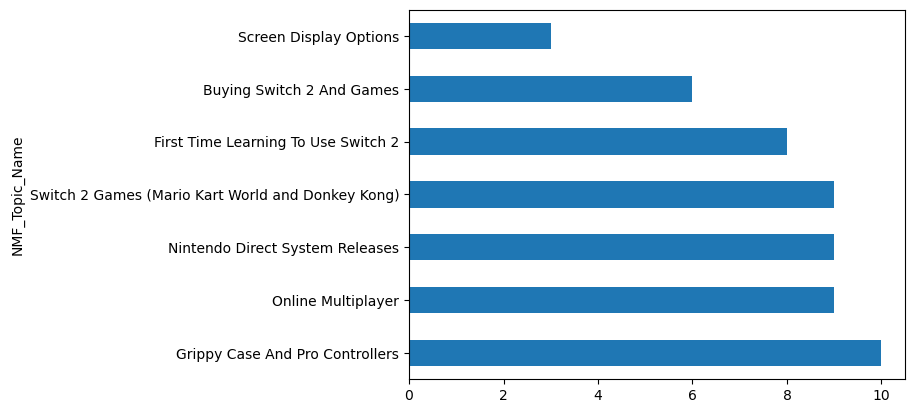

In [58]:
df_pos["NMF_Topic_Name"].value_counts().T.plot(kind='barh')

Based on the above graph, the top three positive posts are related to the Grippy Case and (Pro) Controllers, Online Multiplayer, and the Nintendo Direct System Releases, while the minority positive posts are about Screen Displey Options. It can be infered that most positive posts on the Nintendo Switch 2 Reddit page are about these top three topics indicating positivity toward the new system grip and pro controllers, online multiplayer capabilities, and Nintendo Direct System Releases. Nintendo Direct System Releases refer to a Nintendo event which announces new features, titles, etc. for the Switch 2. <br>
<br>

Nintendo can use this information for further marketing the Nintendo Switch 2 as it is largely positive for consumers.

# Vectorizer on Negative Posts

Now to turn to the negative posts on the Nintendo Switch 2 Reddit page. The same preparation and execution will be performed with limitation to topic modeling parameters given the small number of negative posts.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
import math

The code below will allow us to run the topic modeling on a copy of the original dataframe. After both positive and negative topic modeling are complete they can be joined into the original dataframe for completeness

In [63]:
df_neg = df[df['vader'] == 'negative'].copy()  

In [64]:
df_neg.shape

(20, 10)

In [65]:
df_neg.head(1)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
5,1liuhgu,Fantasy Life i Switch 2 edition cannot suspend the game,https://www.reddit.com/r/NintendoSwitch2/comments/1liuhgu/fantasy_life_i_switch_2_edition_cannot_suspend/,3,1.750718e+09,9,"So I just bought the game, I got the Switch 2 version specifically, and whenever I hit the home button to suspend the game when I go back into it the game becomes completely unresponsive. I have to go back into the home menu, close the software, and reopen. Has anybody else come across this issue?",bought game get switch version specifically whenever hit home button suspend game go back game become completely unresponsive go back home menu close software reopen anybody else come across issue,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'compound': -0.3182}",negative


In [66]:
#additional stop words are added (+) from the positive stop words list and original stop words list to improve topic understanding

nltk_stopwords = stopwords.words("english") 
my_stopwords = nltk_stopwords + ["000", "said", "says","say", "thing", "something", "seem", "anything", "im", "would", "look"] + ["back", "see", "ive"]

In [67]:
# instantiate vectorizer
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words= my_stopwords, 
                        max_df=0.95, 
                        min_df=0.05,
                        ngram_range = (1,2)) 


tfidf_dm = tfidf.fit_transform(df_neg['cleanbody'])

# print matrix shape(s)
print(tfidf_dm.shape)

names = tfidf.get_feature_names_out()
print(type(names), len(names))
#save this feature list for later
big_feature_list = tfidf.get_feature_names_out()

(20, 1159)
<class 'numpy.ndarray'> 1159


In [68]:
print(big_feature_list)

['able' 'able guide' 'across' ... 'yes know' 'youtube' 'youtube game']


In [69]:
count = np.sum(tfidf_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['weight'])

count_df.sort_values(['weight'], ascending = False).head(20)

<class 'list'> 1159


,weight
switch,0.887702
game,0.842366
get,0.643136
play,0.614978
buy,0.593505
work,0.560658
gun,0.559287
use,0.540210
online,0.531711
nintendo,0.479489


# NMF on Negative Reddit Posts

Now the negative posts will be subjected to topic modeling, VADER. The max iterations will be set at 1000 as experimental numbers of topics, number of topic words, and included stop words was consistently returning a Convergence Warning. The number of topics will be 3 and the number of topic words will be 8. We don't want to add too many topics or it will overfit the data due to the small sample size.


In [71]:
from sklearn.decomposition import NMF
from IPython.display import display

In [72]:
def analyze_nmf_topics(tfidf_matrix, vectorizer, n_topics=3, n_top_words=8, random_state=1):
    """
    Fits an NMF model, prints and displays top topic words, and returns topic-word and document-topic DataFrames.
    """
    # Fit the NMF model
    nmf = NMF(n_components=n_topics, random_state=random_state, max_iter = 1000) # max iterations changed to 1000
    doc_topic_matrix = nmf.fit_transform(tfidf_matrix)

    # Extract feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"Vocabulary size: {len(feature_names)}")

    # Get top words per topic
    topic_word_data = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topic_word_data.append([f"Topic {topic_idx + 1}"] + top_words)

    columns = ["Topic"] + [f"Word {i+1}" for i in range(n_top_words)]
    topics_df = pd.DataFrame(topic_word_data, columns=columns)

    print("\nTop words for each topic:")
    display(topics_df)

    return topics_df, doc_topic_matrix, nmf

In [73]:
# need to make sure the parameters for analyze_nmf_topics() align with your object names and parameter ideals
topics_df, doc_topic_matrix, nmf_model = analyze_nmf_topics(tfidf_dm, tfidf, n_topics=3, n_top_words=8)

Vocabulary size: 1159

Top words for each topic:


,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8
0,Topic 1,work,stop,hdr,setting,output,change,tv,fine
1,Topic 2,gun,buy,one,switch,game,player,collection,capcom
2,Topic 3,get,screen,screen protector,protector,live,friend,home,nintendo


### Label Each Topic and Assign It to Document

- Topic 1: Screen And Video Settings
- Topic 2: Purchasing Switch 2 And Games
- Topic 3: Screen Protector


In [75]:
# Assign the best-fit topic index (1-indexed) for each document
df_neg["NMF_Topic_Neg"] = doc_topic_matrix.argmax(axis=1) + 1  # +1 to match "Topic 1", "Topic 2", ...

Now the custom topic names are applied to each document.

In [77]:
custom_topic_names = {
    1: "Screen And Video Settings", 
    2: "Purchasing Switch 2 And Games",
    3: "Screen Protector",
}

In [78]:
df_neg["NMF_Topic_Name"] = df_neg["NMF_Topic_Neg"].map(custom_topic_names)

In [212]:
df_neg["NMF_Topic_Name"].value_counts()

NMF_Topic_Name
Purchasing Switch 2 And Games    10
Screen Protector                  5
Screen And Video Settings         5
Name: count, dtype: int64

In [214]:
# Percentage of topic frequency per number of negative posts

df_neg["NMF_Topic_Name"].value_counts()/(df_neg["NMF_Topic_Name"].value_counts().sum())*100

NMF_Topic_Name
Purchasing Switch 2 And Games    50.0
Screen Protector                 25.0
Screen And Video Settings        25.0
Name: count, dtype: float64

<Axes: ylabel='NMF_Topic_Name'>

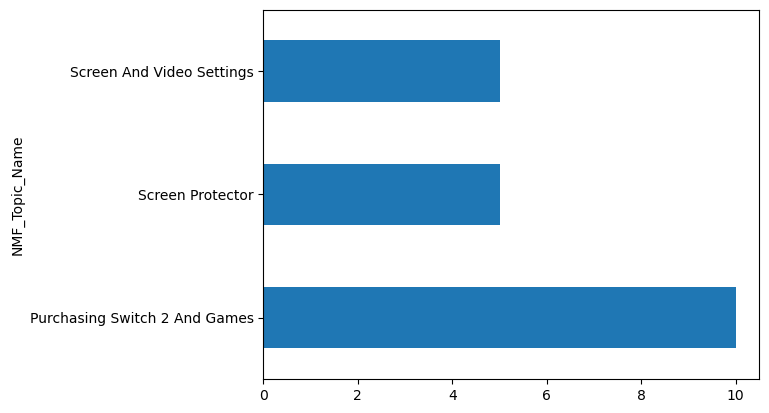

In [80]:
df_neg["NMF_Topic_Name"].value_counts().T.plot(kind='barh')

There is less to gain from analyzing the negative posts and majority of this reasoning is due to sample size. Had there been 1,000 posts analyzed instead of 100 the number of negative posts would have likely increased allowing for topic modeling to be more fruitful. It is difficult for topic modeling to work when there are limited important words for an already limited sample size (this can lead to overfitting). This made it so that some topics were entirely based on one post. While, in theory, increasing the number of topic words could help increase the interpretability of the analysis, it would most likley actually hurt it due to each topic being represented solely. The three topics that were output are limited but concise in what they represent. Their distribution is not great but actually not terrible given the sample size.<br>
 <br>
These three topics shed light on possible fixings that are desired to occur with the Switch 2 for fans. First, purchasing the Switch 2 and games can refer to the difficulty of finding stock for these items, the change for Switch 2 games to be entirely virtual, or even the available games to purchase being limited. Second, referring to a screen protector indicates that the Switch 2 may be fragile and therefore in order for a consumer to protect their purchase they would be almost required to buy an expensive screen protector on top of their system itself. Thirdly, screen and video settings being referred to is interesting as it was also referred to in the positive, but only in three instances for the positive posts and five in the negative posts. In the big picture for a business, these may cancel out as there seems to be content and discontent with it, making the need for change heavily more subjective than factual.
<br>
 <br>
Nintendo can use this information for further changing the Nintendo Switch 2. Although this analysis may not yield as crucial information as one that is larger, it points out individuals and their struggles with the game console.

# Joining df_pos and df_neg to Original DataFrame

I want to recombine the dataframes with their topic modeling data, but I was having trouble initially. In order to do this I needed to splice the df_neg and df_pos dataframes to include the 'NMF_Topic_Neg' and 'NMF_Topic_Pos' respectively, the 'NMF_Topic_Name', as well as the 'id' to be used as our joining key. From there each splice was joined (outer join) into the original dataframe.  Doing this created two 'NFM_Topic_Name' columns 'x' and 'y'. These needed to be merged to complete the column as one and also allow us to drop any additional less useful columns ('NMF_Topic_Name_y' and 'NMF_Topic_Name_x'). Finally, the columns were re-arranged in a more ideal order using the loc function.


__Sources used to join and manipulate data frames__
- https://www.geeksforgeeks.org/python/different-types-of-joins-in-pandas/<br>
<br>
- https://www.geeksforgeeks.org/data-science/slicing-indexing-manipulating-and-cleaning-pandas-dataframe/

In [84]:
df_neg.columns

Index(['id', 'title', 'url', 'score', 'created_utc', 'num_comments', 'body',
       'cleanbody', 'vader_scores', 'vader', 'NMF_Topic_Neg',
       'NMF_Topic_Name'],
      dtype='object')

In [85]:
df1 = pd.DataFrame(df_neg, columns = ['id','NMF_Topic_Neg','NMF_Topic_Name']).copy()
df1.head(2)

,id,NMF_Topic_Neg,NMF_Topic_Name
5,1liuhgu,3,Screen Protector
10,1lismop,1,Screen And Video Settings


In [86]:
type(df1)

pandas.core.frame.DataFrame

In [87]:
df1_merge = pd.merge(df1, df, on= 'id', how='outer')
df1_merge.head(1)

,id,NMF_Topic_Neg,NMF_Topic_Name,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader
0,1lhn0sn,NaN,NaN,Bought donkey kong bananza with amiibo for only €70 !,https://i.redd.it/1tq6wpyk5h8f1.jpeg,0,1.750596e+09,21,NaN,nan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral


In [88]:
df_pos.columns

Index(['id', 'title', 'url', 'score', 'created_utc', 'num_comments', 'body',
       'cleanbody', 'vader_scores', 'vader', 'NMF_Topic_Pos',
       'NMF_Topic_Name'],
      dtype='object')

In [89]:
df2 = pd.DataFrame(df_pos, columns = ['id','NMF_Topic_Pos', 'NMF_Topic_Name'])
df2.head(2)

,id,NMF_Topic_Pos,NMF_Topic_Name
0,1lix8gh,2,Grippy Case And Pro Controllers
2,1lix33y,5,Online Multiplayer


In [90]:
df2_merge = pd.merge(df1_merge, df2, on='id', how='outer')

In [91]:
df2_merge.head(1)

,id,NMF_Topic_Neg,NMF_Topic_Name_x,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader,NMF_Topic_Pos,NMF_Topic_Name_y
0,1lhn0sn,NaN,NaN,Bought donkey kong bananza with amiibo for only €70 !,https://i.redd.it/1tq6wpyk5h8f1.jpeg,0,1.750596e+09,21,NaN,nan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,NaN,NaN


In [92]:
df2_merge['NMF_Topic_Name'] = df2_merge['NMF_Topic_Name_y'].fillna(df2_merge['NMF_Topic_Name_x'])
df2_merge.head(1)

,id,NMF_Topic_Neg,NMF_Topic_Name_x,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader,NMF_Topic_Pos,NMF_Topic_Name_y,NMF_Topic_Name
0,1lhn0sn,NaN,NaN,Bought donkey kong bananza with amiibo for only €70 !,https://i.redd.it/1tq6wpyk5h8f1.jpeg,0,1.750596e+09,21,NaN,nan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,NaN,NaN,NaN


In [93]:
df_comb = df2_merge.drop(columns = ['NMF_Topic_Name_x', 'NMF_Topic_Name_y'])

In [94]:
df_comb.columns

Index(['id', 'NMF_Topic_Neg', 'title', 'url', 'score', 'created_utc',
       'num_comments', 'body', 'cleanbody', 'vader_scores', 'vader',
       'NMF_Topic_Pos', 'NMF_Topic_Name'],
      dtype='object')

In [95]:
df_comb = df_comb.loc[:, ['id','title', 'url', 'score', 'created_utc',
       'num_comments', 'body', 'cleanbody', 'vader_scores', 'vader',
       'NMF_Topic_Pos', 'NMF_Topic_Neg', 'NMF_Topic_Name']]

In [96]:
df_comb.head(2)

,id,title,url,score,created_utc,num_comments,body,cleanbody,vader_scores,vader,NMF_Topic_Pos,NMF_Topic_Neg,NMF_Topic_Name
0,1lhn0sn,Bought donkey kong bananza with amiibo for only €70 !,https://i.redd.it/1tq6wpyk5h8f1.jpeg,0,1.750596e+09,21,NaN,nan,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,NaN,NaN,NaN
1,1lhn7ek,If you're in the New York Metro Area,https://www.reddit.com/r/NintendoSwitch2/comments/1lhn7ek/if_youre_in_the_new_york_metro_area/,0,1.750597e+09,29,"I strongly recommend going to the Nintendo store before they open, following the advice of someone else here I was able to get a Warp Pass by going in person",strongly recommend go nintendo store open follow advice someone else able get warp pas go person,"{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.5574}",positive,5.0,NaN,Online Multiplayer


# Combined Analysis

A comparison table allows us to see the positive and negative document totals based on the custom topic they are part of. This is very useful for visualization and analysis.

In [188]:
comparison_table = pd.crosstab(df_comb['NMF_Topic_Name'], df_comb['vader'])

print(comparison_table)

vader                                              negative  positive
NMF_Topic_Name                                                       
Buying Switch 2 And Games                                 0         6
First Time Learning To Use Switch 2                       0         8
Grippy Case And Pro Controllers                           0        10
Nintendo Direct System Releases                           0         9
Online Multiplayer                                        0         9
Purchasing Switch 2 And Games                            10         0
Screen And Video Settings                                 5         0
Screen Display Options                                    0         3
Screen Protector                                          5         0
Switch 2 Games (Mario Kart World and Donkey Kong)         0         9


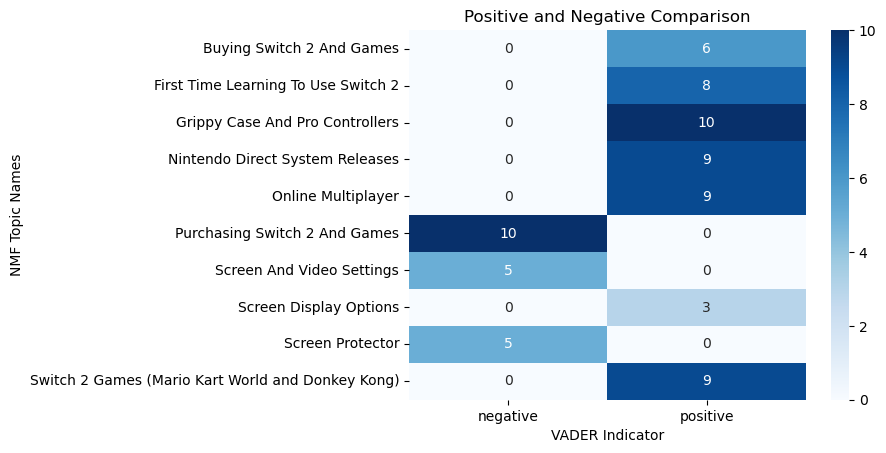

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(comparison_table, annot=True, fmt='d', cmap='Blues')
plt.title('Positive and Negative Comparison')
plt.xlabel('VADER Indicator') 
plt.ylabel('NMF Topic Names')
plt.show()

The above heatmap graph of the comparison table compares the NMF Topic Names, and the number of documents for each, grouped by their VADER indicator. This allows us to see the data from a different perspective and make inferences based on it. For example: there are three total topic names regarding the switch 2 screen hardware, two of which are negative and one that is positive. The negative concentration is higher and therefore alludes to a potential problem with the screen and the need for Nintendo to make screen changes in newer Switch 2 models (Switch 2 Pro?) or future Nintendo systems. <br>
<br>The next big peice of information we see is the polarity of negative and positive posts about purchasing switch 2 and games. While there is large positivity with some of the games (particularly Mario Kart World and Donkey Kong) and purchasing of the system, there is also concentrated negativity within the few negative posts present. This could mean that the Switch 2 is difficult for some consumer to get a hold of or that there may be a lack of newer games to be able to play on the Switch 2, while other consumers feel the opposite about it. These contradicting scores indicate a level of subjectivity within themselves and further analysis of more data may show concrete sentiment toward positive or negative.